<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/Updated_NBSVM_Submission_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings

import lightgbm as lgb

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-' ]         
                
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
################### Compare with baseline TF-IDF features ###################

# TF-IDF Vectorizer
train_text = train['clean_lemmed_str']

word_vectorizer = TfidfVectorizer(
    min_df = 3,
    max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)

char_vectorizer = TfidfVectorizer(
    min_df = 3,
    max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(train_text)
train_char_features = char_vectorizer.transform(train_text)

train_tfidf_features = hstack([train_char_features, train_word_features]).tocsr()

# Create features about type of text and category of text
def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[.!\?=+#*|~-]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC]ock", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    df["nb_ng_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigga\W", x))

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))

    
#add_features(train)
#pos_tagging(df)
#pos_features(df)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [0]:
################### Doc2Vec Feature Engineering ###################
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

corpus = df['clean_lemmed'].to_list() 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

# Set values for various parameters
vector_size = 100    # Document vector dimensionality  
window = 5   # Context window size                                                                                    
min_count = 5   # Minimum word count                        
sample = 1e-2   # Which higher-frequency words are randomly downsampled
dm = 1          # dm {0,1} = 1 if PV-DM, 0 if PV-DBOW
epochs = 100     # epochs = number of training epochs over corpus (default 5)

start_time = time.time()
model = Doc2Vec(documents, 
                vector_size=vector_size,
                window=window, 
                min_count=min_count, 
                sample = sample,
                workers=4, 
                epochs = epochs)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

train_features = sparse.csr_matrix(np.array([model.docvecs[i] for i in range(train_text.shape[0])]))
print(train_features.shape)

# Use this if train features creates too many rows of data (using df, not train)
#if train_features.shape[0] > train_text.shape[0]:
#  index_to_use = list(range(train_text.shape[0]))
#  train_features = train_features[index_to_use]

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1, multi_class='auto'):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.multi_class = multi_class

    def predict(self, x):
        # Verify that model has been fit
        #check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        #check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [0]:
# Set LGBM parameters
params = {
    "objective": "binary",
    'metric': {'auc'},
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1
    #"min_split_gain": .1,
    #"reg_alpha": .1
}

fit:  toxic  | mean AUC:  0.9715


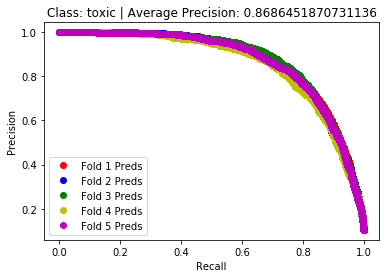

fit:  severe_toxic  | mean AUC:  0.9814


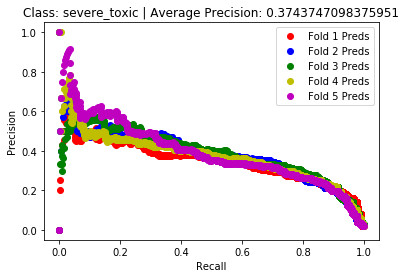

fit:  obscene  | mean AUC:  0.9904


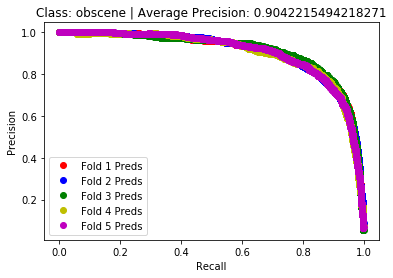

fit:  threat  | mean AUC:  0.8212


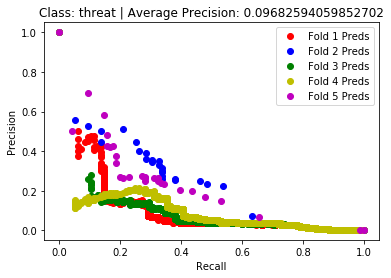

fit:  insult  | mean AUC:  0.9771


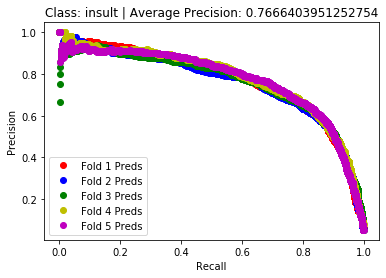

fit:  identity_hate  | mean AUC:  0.9714


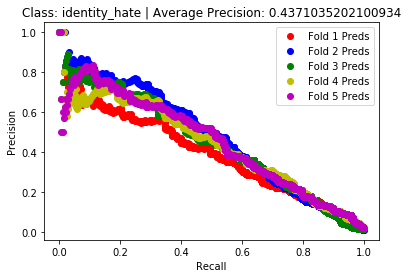

In [5]:
##### Fit LGB Model #####
warnings.filterwarnings("ignore")

train_features = train_tfidf_features

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

trn_lgbset = lgb.Dataset(train_features, free_raw_data=False)
lgb_rounds = 500
for i, j in enumerate(class_names):
    training_labels = train[j]
    class_pred = np.zeros(len(train))
    trn_lgbset.set_label(training_labels.values)
    auc,precision,recall,thresholds = [],[],[],[]

    # Make predictions for each fold in split, calculate evaluation metrics
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train lgb l1
      model = lgb.train(params=params,train_set=trn_lgbset.subset(trn_idx),
          num_boost_round=lgb_rounds, valid_sets=[trn_lgbset.subset(val_idx)],
          early_stopping_rounds=50,
          verbose_eval=0)
      class_pred[val_idx] = model.predict(trn_lgbset.data[val_idx], num_iteration=model.best_iteration)
      auc.append(roc_auc_score(training_labels.values[val_idx], class_pred[val_idx],average='weighted'))
      prec, recal, thresh = precision_recall_curve(training_labels.values[val_idx], class_pred[val_idx])
      precision.append(prec)
      recall.append(recal)
      thresholds.append(thresh)

    # Print out mean AUC score
    print("fit: ",j,' | mean AUC: ',str(round(np.mean(auc),4)))
    print("Thresholds: "+str(thresholds[4]))
    print("Precision: "+str(precision[4]))
    # Plot precision-recall curve
    plt.figure()
    plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
    plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
    plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
    plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
    plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class: '+j+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
    plt.legend()
    plt.show()
    



In [0]:
## Run all pre-processing code at once

##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile

import lightgbm as lgb

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc]         
                
df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## ========== Feature Engineering=====================

# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Which higher-frequency words are randomly downsampled
sg = 1          # sg {0,1} = 1 if skip-gram, 0 if CBOW,
epochs = 100     # epochs = number of training epochs over corpus (default 5)

tokenized_corpus = df['clean_comments_list']

# Fit FastText model on pre-processed corpus
start_time = time.time()
#ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
#                    min_count=min_word_count,sample=sample, sg=sg, iter=epochs)
model = Word2Vec(tokenized_corpus, size=feature_size, window=window_context, 
                 min_count=min_word_count, sample=sample, sg=sg, iter=epochs)
print("--- %s minutes ---" % ((time.time() - start_time)/60))
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

word2vec = model
X = train['clean_lemmed_str']

def tf2vec_fit(X):
    #tfidf = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer=lambda x: x)
    tfidf = TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      stop_words='english',
      ngram_range=(1, 2),
      max_features=40000)
    tfidf.fit(X)
    # if a word was never seen - it must be at least as infrequent
    # as any of the known words - so the default idf is the max of 
    # known idf's
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight

def transform(X,word2weight):
        return np.array([
                np.mean([word2vec[w] * word2weight[w]
                         for w in words if w in word2vec] or
                        [np.zeros(feature_size)], axis=0)
                for words in X
            ])

def tf2vec_transform(X, word2weight):
    return sparse.csr_matrix([
                np.mean([word2vec[w] * word2weight[w]
                         for w in words if w in word2vec] or 
                        [np.zeros(feature_size)], axis=0)
            for words in X])
    
tf2vec_features = transform(X,tf2vec_fit(X))
train_features = sparse.csr_matrix(tf2vec_features)

## Shift Word Embedding Vectors for NB equation
#print(train_features.shape)
min_val = np.min(train_features.data)
shift_val = round((min_val * -1) + 1,0)

def shift_elements(mat):
    x = mat.copy()
    cx = x.tocoo()    
    for i,j,v in zip(cx.row, cx.col, cx.data):
        x[i,j] = v + shift_val
    return x

shifted_csr = shift_elements(train_features)

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
seed = 1234
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
preds = {}

# Set LGBM parameters
params = {
    "objective": "binary",
    'metric': {'auc'},
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1
    #"min_split_gain": .1,
    #"reg_alpha": .1
}


In [0]:
##### Fit LGB Model #####
import warnings
warnings.filterwarnings("ignore")

trn_lgbset = lgb.Dataset(train_features, free_raw_data=False)
lgb_rounds = 500
for i, j in enumerate(class_names):
    training_labels = train[j]
    trn_lgbset.set_label(training_labels.values)
    scores = []
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train lgb l1
      model = lgb.train(params=params,train_set=trn_lgbset.subset(trn_idx),
          num_boost_round=lgb_rounds, valid_sets=[trn_lgbset.subset(val_idx)],
          early_stopping_rounds=100,
          verbose_eval=0)
      preds[j] = model.predict(trn_lgbset.data[val_idx], num_iteration=model.best_iteration)
      # pred_probs =  model.predict_proba(trn_lgbset.data[val_idx], num_iteration=model.best_iteration)
      scores.append(roc_auc_score(training_labels.values[val_idx], preds[j]))

      """
      ## Calculate ROC curves
      from sklearn.metrics import roc_curve
      pred_probs = model.predict_proba(trn_lgbset.data[val_idx], num_iteration=model.best_iteration)
      ns_probs = [0 for _ in range(len(training_labels.values[val_idx]))]

      clf_fpr, clf_tpr, _ = roc_curve(training_labels.values[val_idx], pred_probs)
      ns_fpr, ns_tpr, _ = roc_curve(training_labels.values[val_idx], ns_probs)

      # Plot ROC curves
      plt.figure(6,6)
      plt.plot(clf_fpr, clf_tpr, marker='.', label='{} Classifier for fold {}'.format(j,n_fold))
      plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend()
      plt.show()
      """
    print('fit: ' + j + ' | score: ' + str(round(np.mean(scores),3)))


In [0]:
###### Randomized Search #####
from pprint import pprint
from scipy.stats import truncnorm, uniform, lognorm, norm
seed = 1234

for i, j in enumerate(class_names):
    training_labels = train[j]
    training_labels = train[j]
    logistic = LogisticRegression(C=0.1, tol=1e-4, solver='saga',class_weight ='balanced',max_iter=1000)
    model_params = {
      # randomly sample numbers for C parameter
      'C': randint(4,200)
      # normally distributed max_features, with mean .25, stddev .1, bounded between 0,1
      'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
      # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
      'min_samples_split': uniform(0.01, 0.199)
    }
    clf = RandomizedSearchCV(logistic, model_params, n_iter=100, cv=5, random_state=seed)
    model = clf.fit(train_features, training_labels)
    pprint(model.best_estimator_.get_params())              